In [1]:
import numpy as np
import pandas as pd
import pickle

In [2]:
data = pickle.load(open('../data/60_second_data.p','rb'))

In [57]:
from hrvanalysis import get_time_domain_features
from joblib import Parallel,delayed

In [71]:
def get_data(a):
    features = []
    ecg_rr = a[:,-1]
    ecg_rr = ecg_rr[~np.isnan(ecg_rr)]
    for i in [-2,-3,-4]:
        ppg_rr = a[:,i]
        ppg_qual = a[:,i-3]
        index = ppg_rr>0
        ppg_qual = ppg_qual[index]
        ppg_rr = ppg_rr[index]
        index = ~np.isnan(ppg_rr)
        ppg_qual = ppg_qual[index]
        ppg_rr = ppg_rr[index]
        if len(ppg_rr)<10:
            continue
        f = list(get_time_domain_features(ppg_rr).values())
        f1 = list(get_time_domain_features(ecg_rr).values())
        q = [np.median(ppg_qual),np.mean(ppg_qual),len(ppg_rr)/60]
        features.append(np.array(f1+f+q))
    return np.array(features)

df_col = Parallel(n_jobs=10,verbose=1)(delayed(get_data)(a) for a in data if len(a[~np.isnan(a[:,-1]),-1])>10)    

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    4.2s
[Parallel(n_jobs=10)]: Done 1940 tasks      | elapsed:    5.6s
[Parallel(n_jobs=10)]: Done 5475 out of 5475 | elapsed:    7.9s finished


In [67]:
feature_col = ['mean_nni', 'sdnn', 'sdsd', 'nni_50', 'pnni_50', 'nni_20', 'pnni_20', 'rmssd',
 'median_nni', 'range_nni', 'cvsd', 'cvnni', 'mean_hr', 'max_hr', 'min_hr', 'std_hr']
quality_col = ['median','mean','length']
X = np.concatenate(df_col,axis=0)
X.shape

(16425, 38)

In [68]:
quality = X[:,-3:]
features = X[:,16:-3]
features_ecg = X[:,:16]

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline
def output(qual,ground_truth,features,f_name,q_name):
    l_range = np.arange(0,1,.05)
    x = []
    y = []
    for l in l_range:
        index = np.where((qual>=l)&(qual<l+.05))[0]
        if len(index)<2:
            continue
        temp_input = features[index]
        temp_output = ground_truth[index]
        x.append(str(np.round(l*100)/100)+'-'+str(np.round((l+.05)*100)/100))
        y.append(list(np.abs(temp_input-temp_output)))

    plt.figure(figsize=(10,8))
    plt.rcParams.update({'font.size':20})
    plt.boxplot(y,showfliers=False)
    plt.xticks(range(1,len(x)+1),x,rotation=60)
    plt.ylabel('Absolute Difference in Milliseconds-'+str(f_name))
    plt.xlabel('Range of Signal Quality-'+str(q_name))
    plt.tight_layout()
    plt.show()



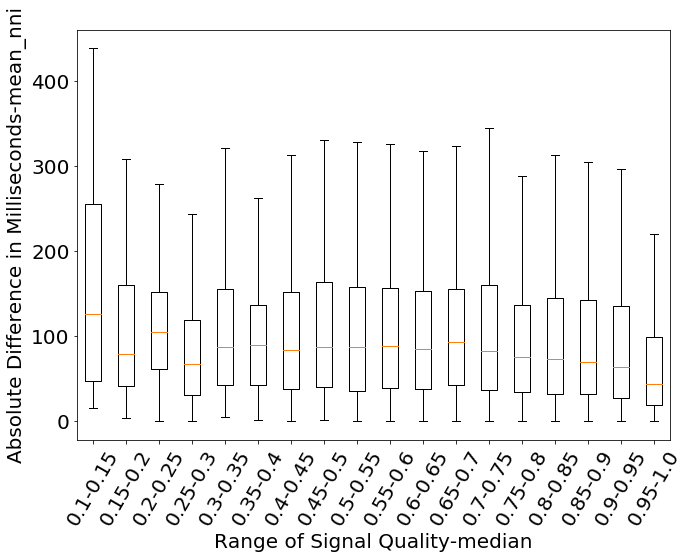

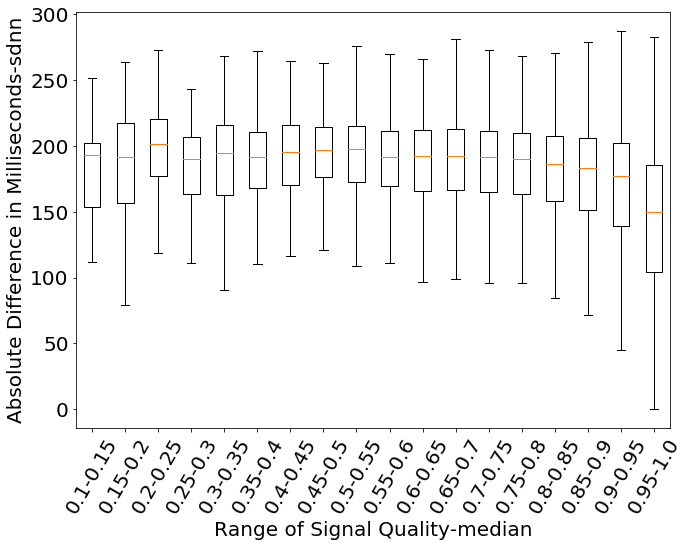

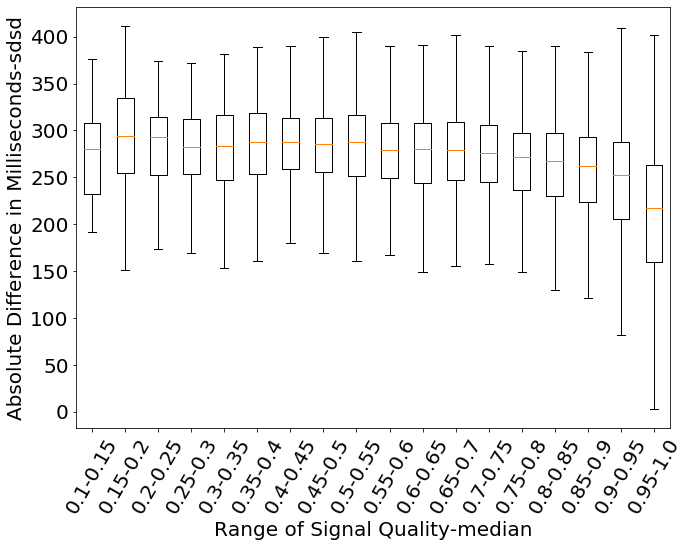

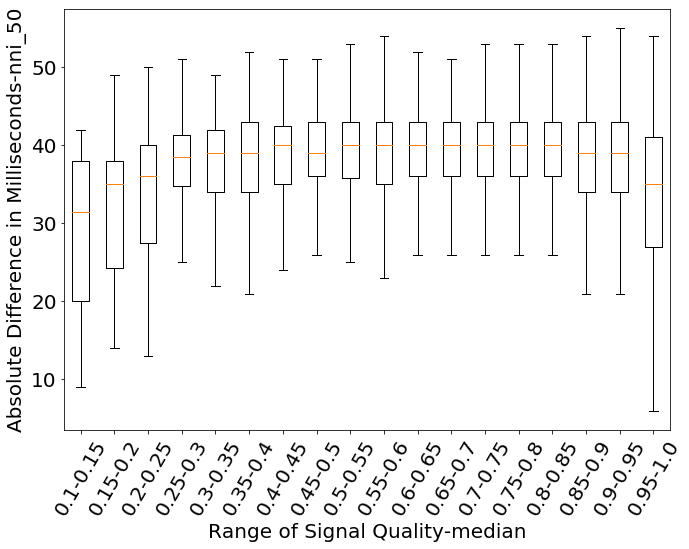

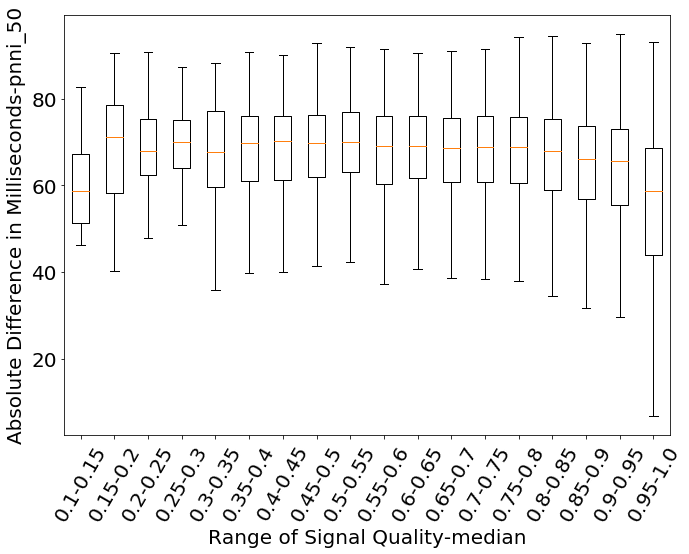

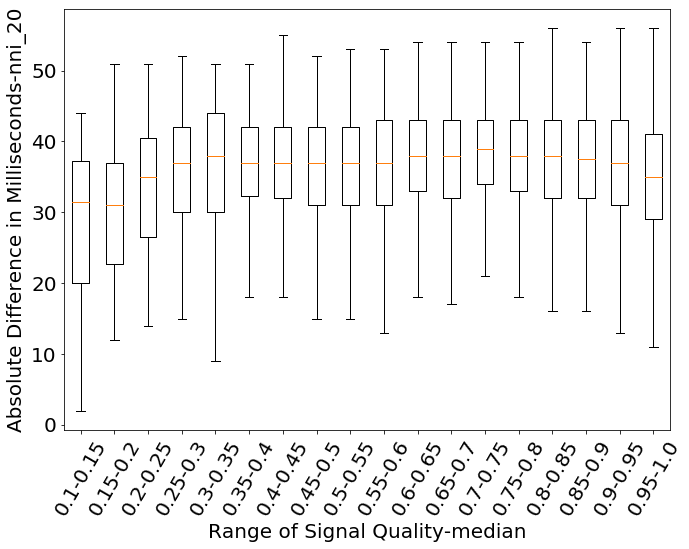

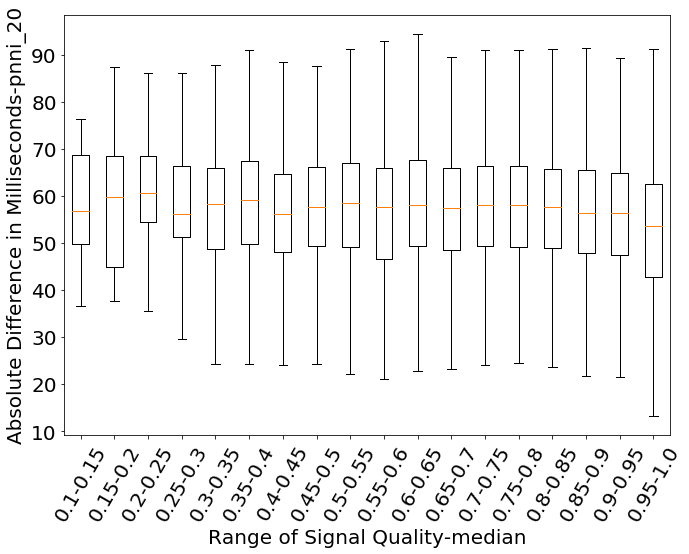

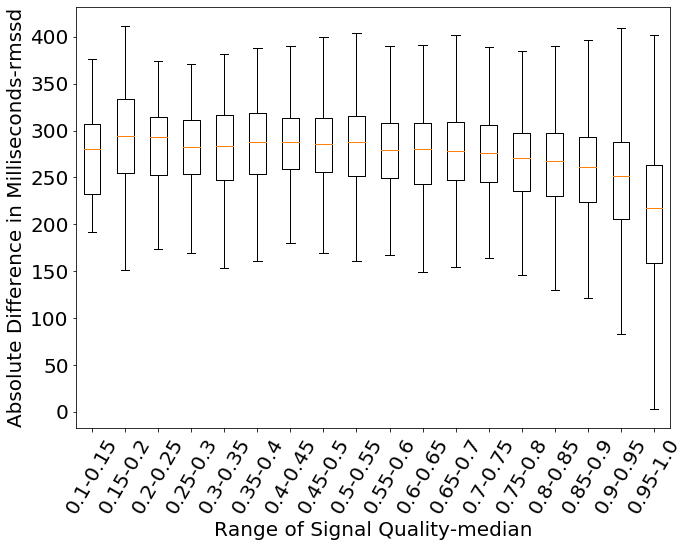

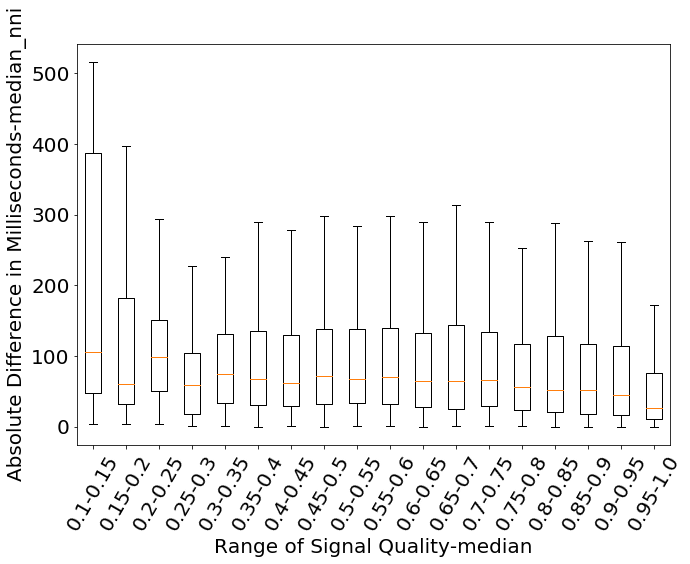

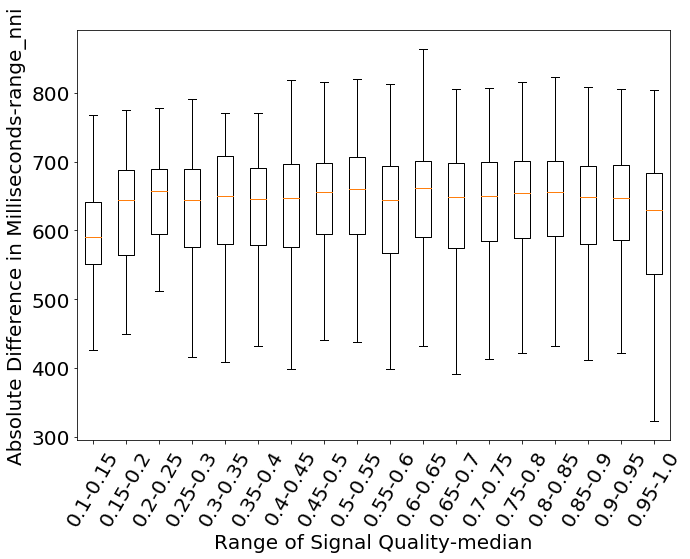

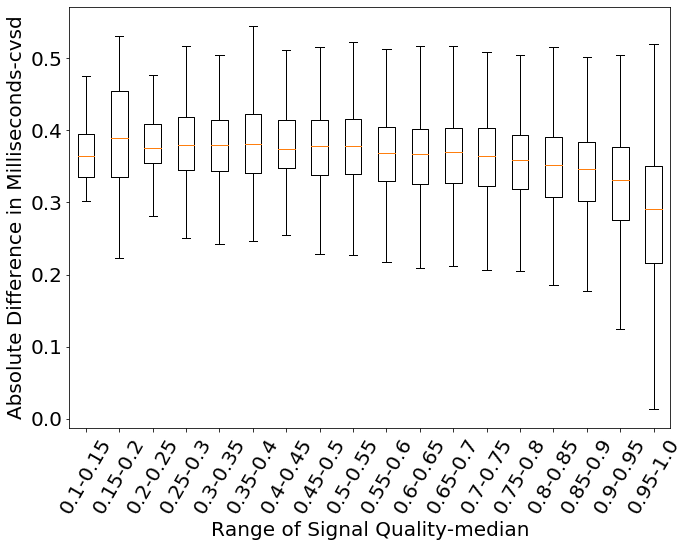

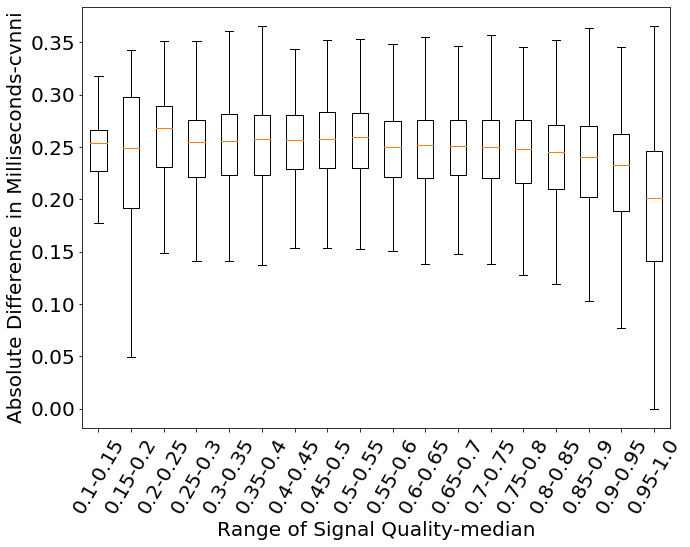

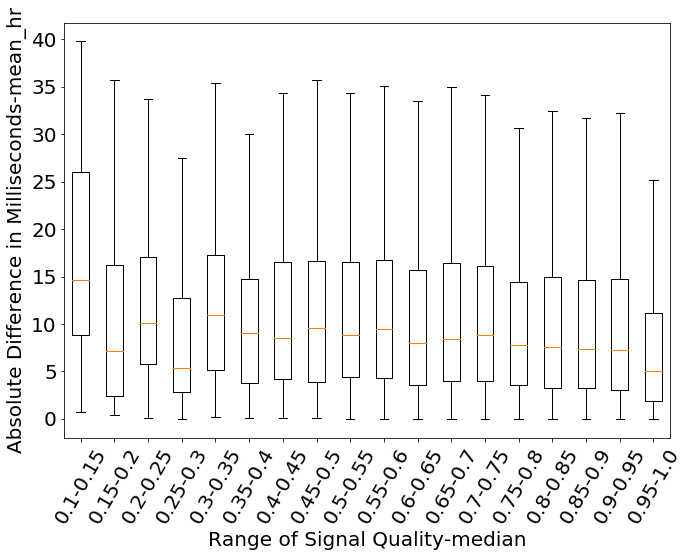

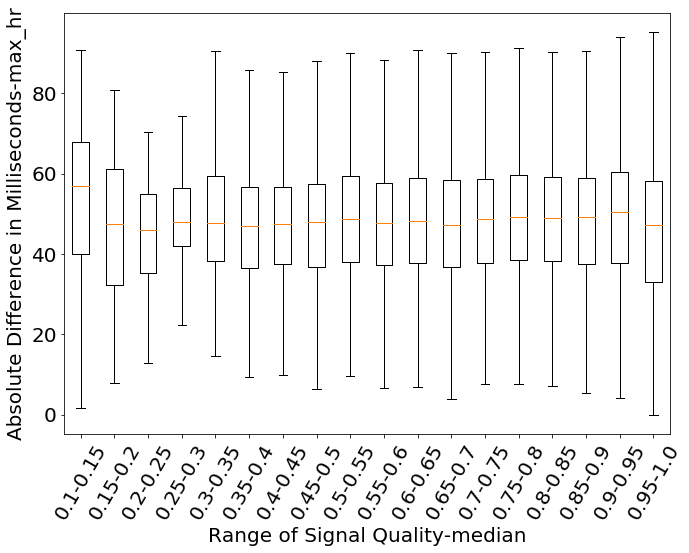

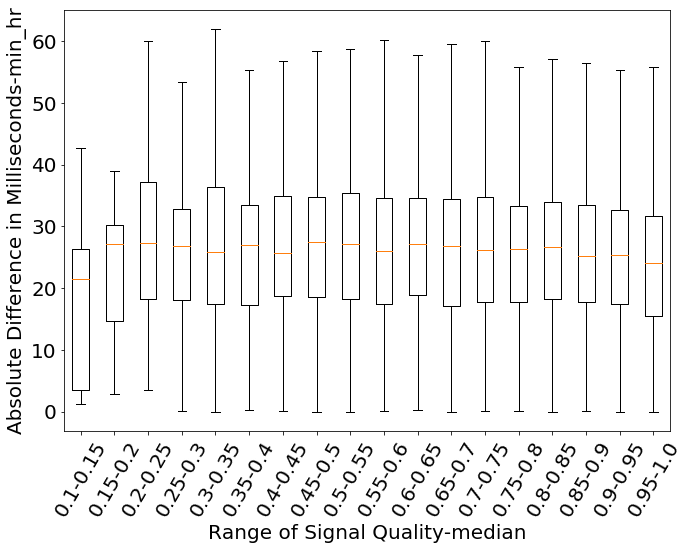

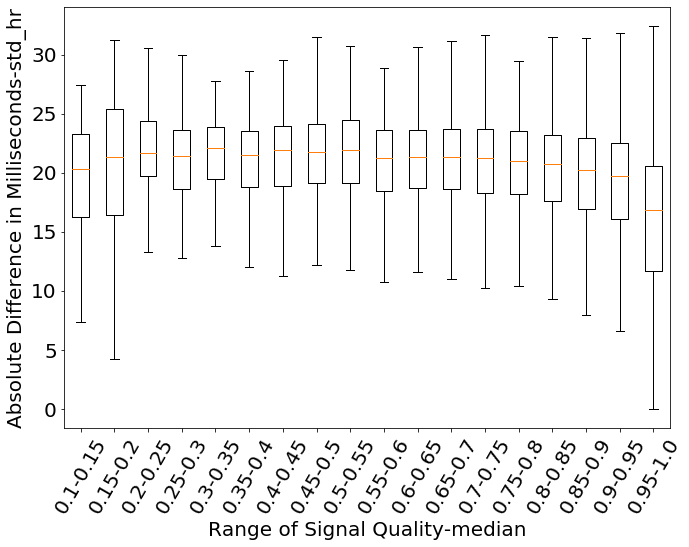

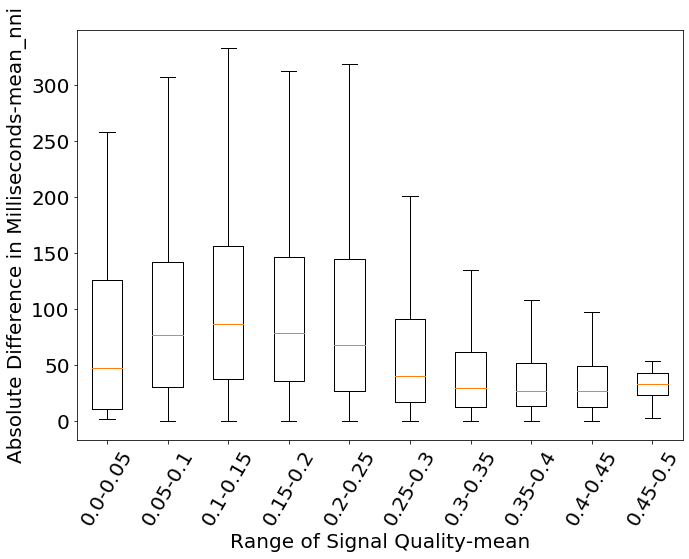

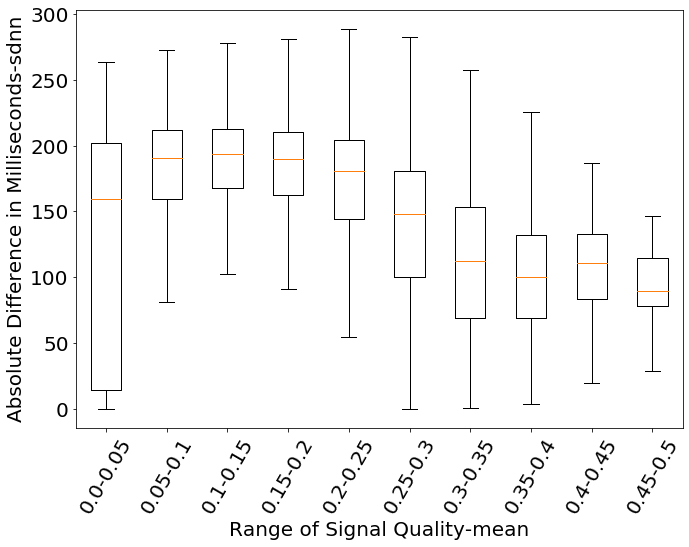

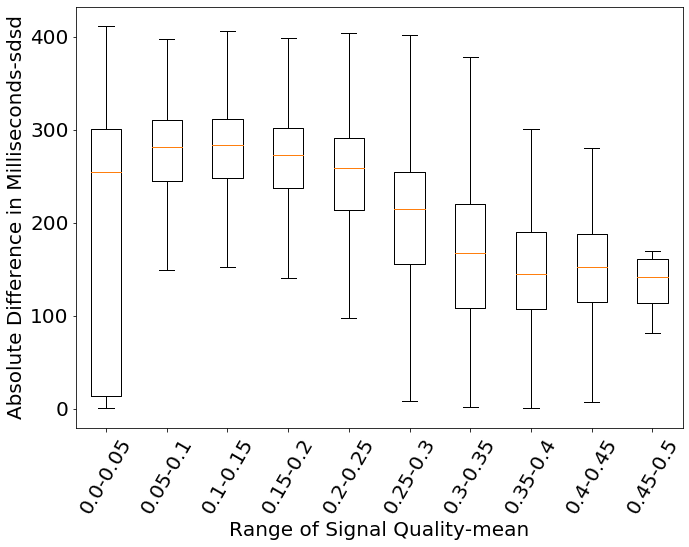

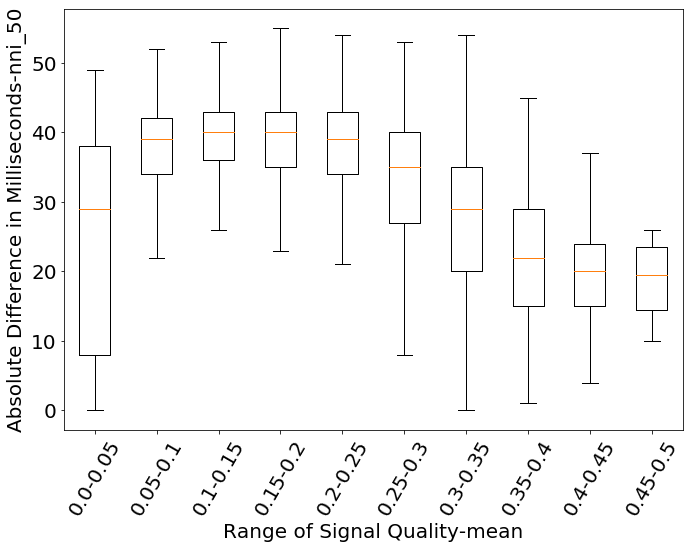

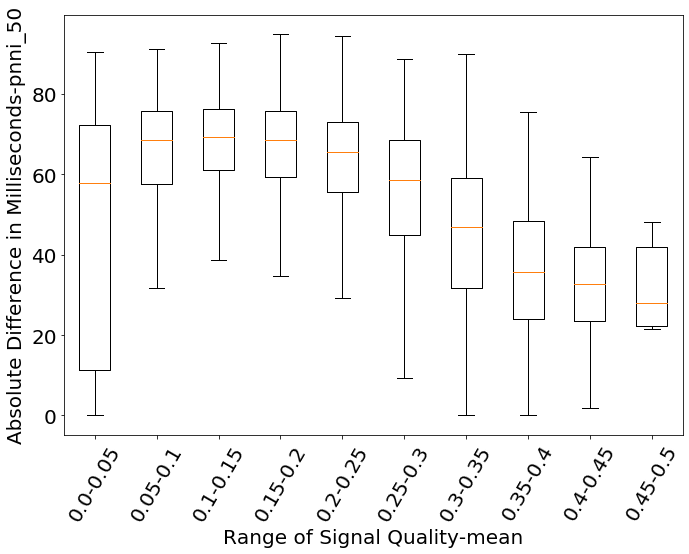

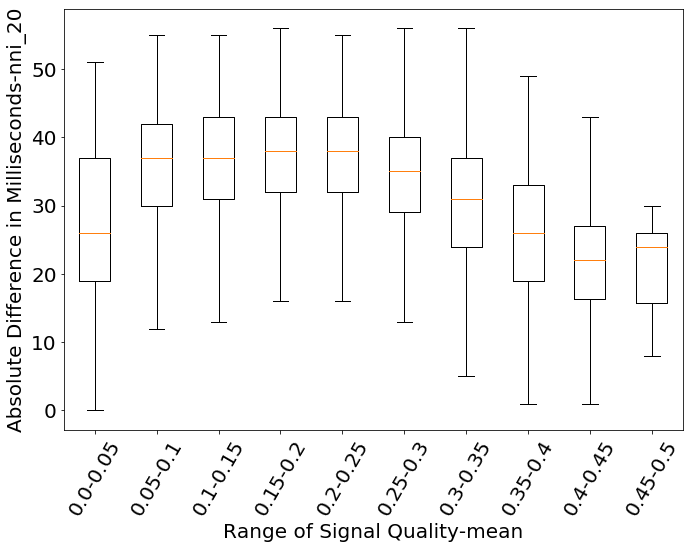

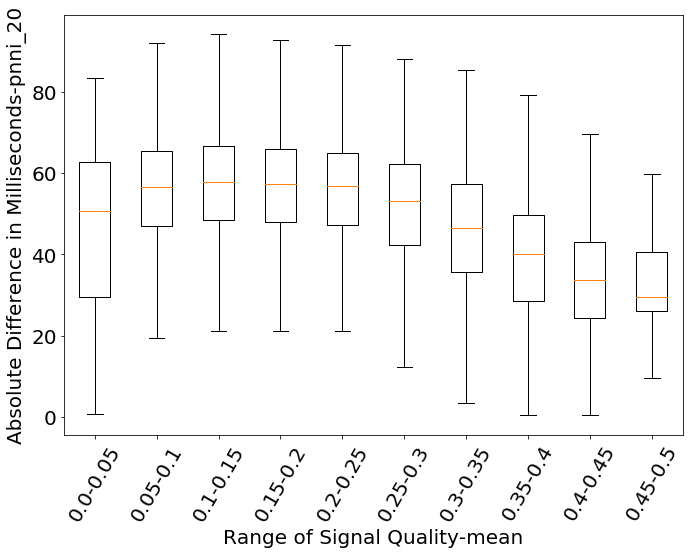

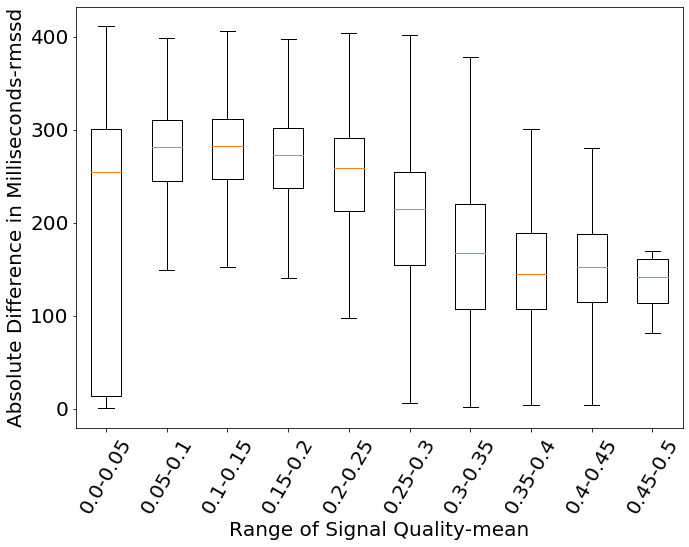

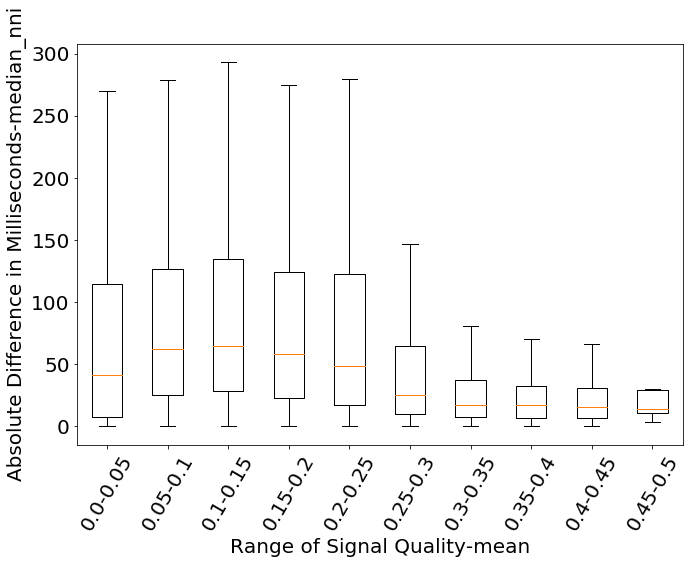

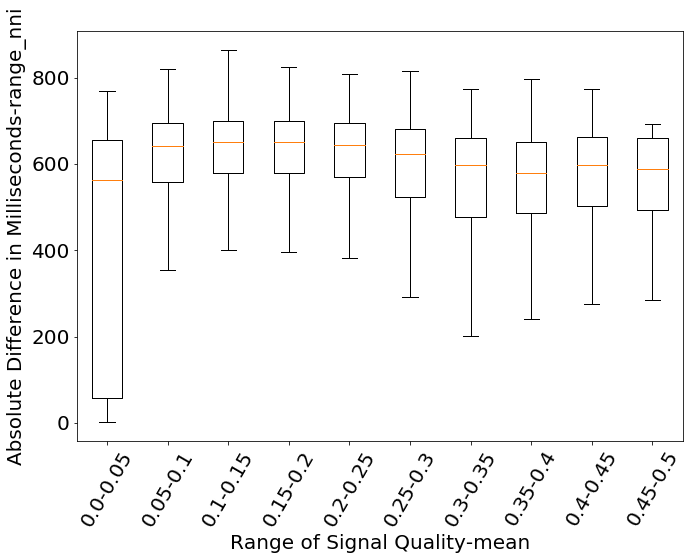

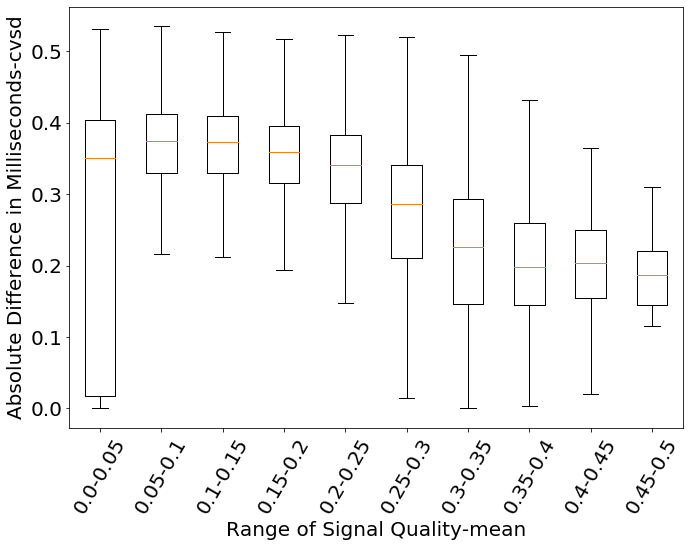

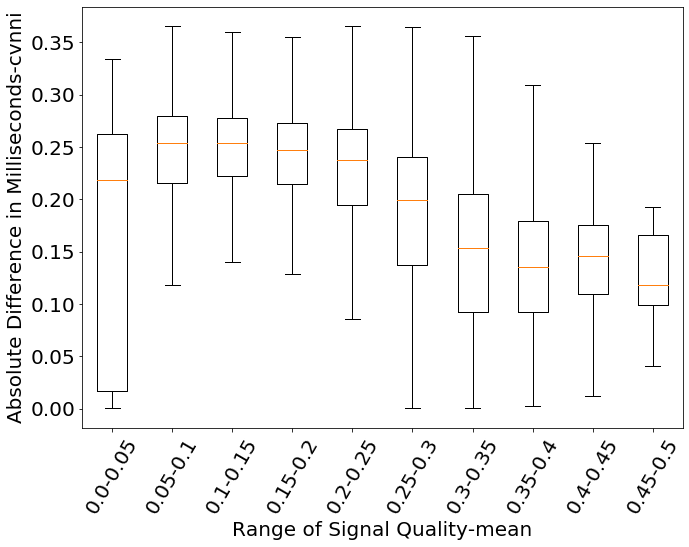

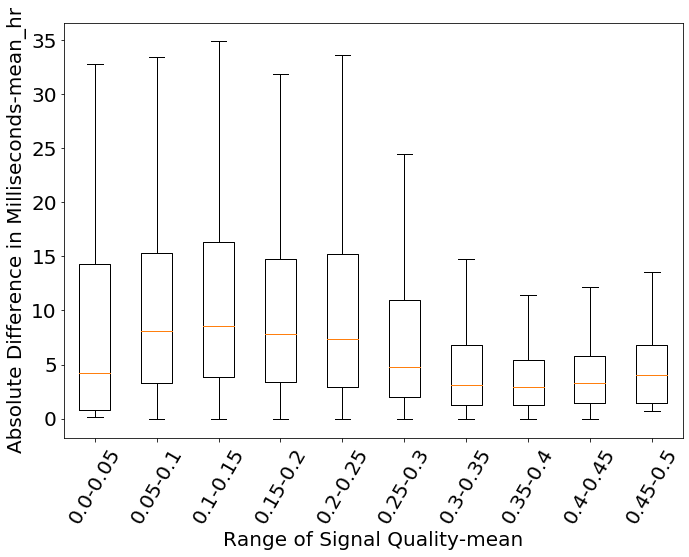

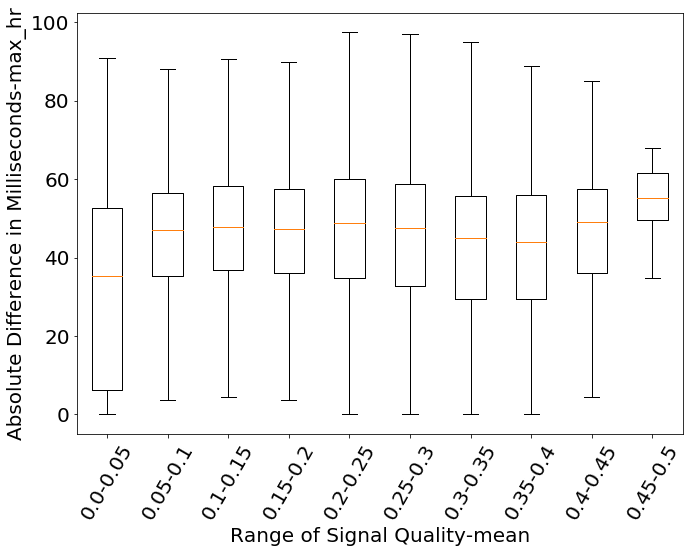

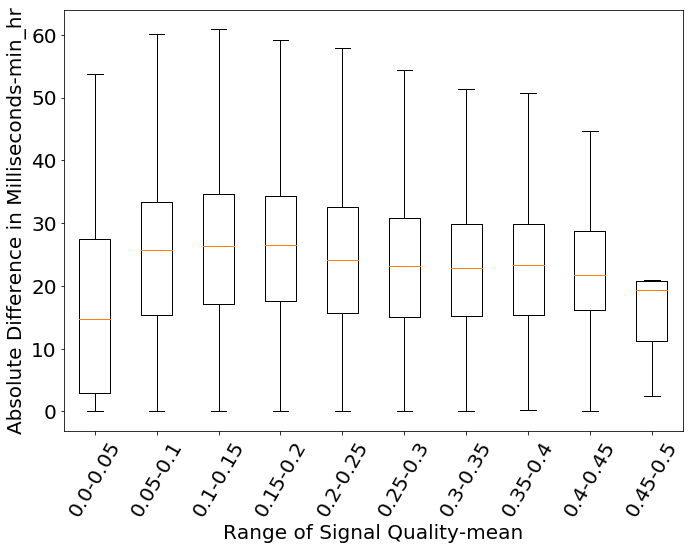

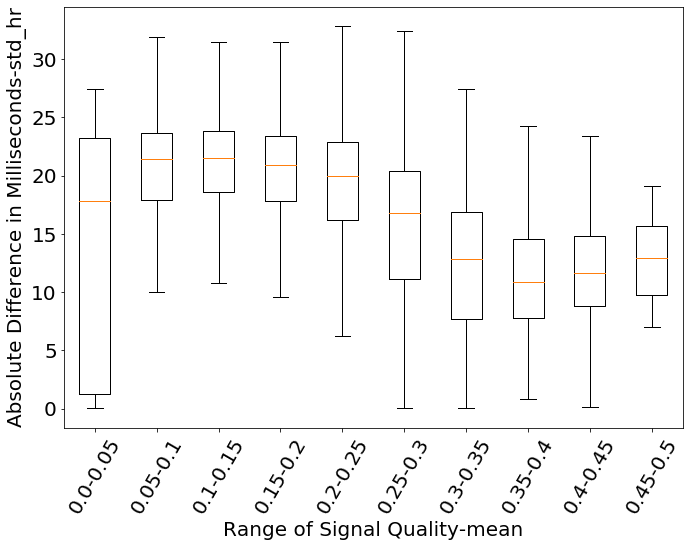

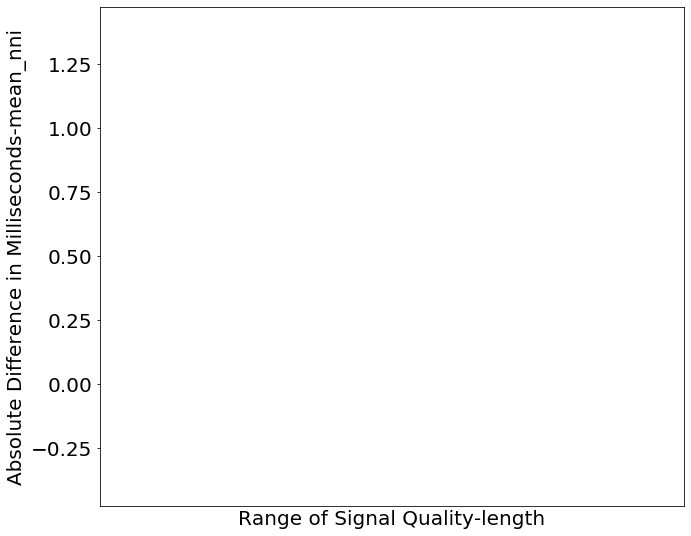

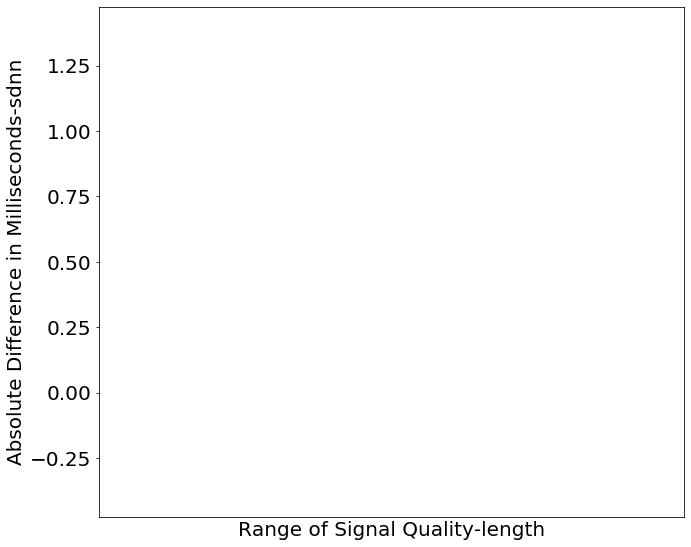

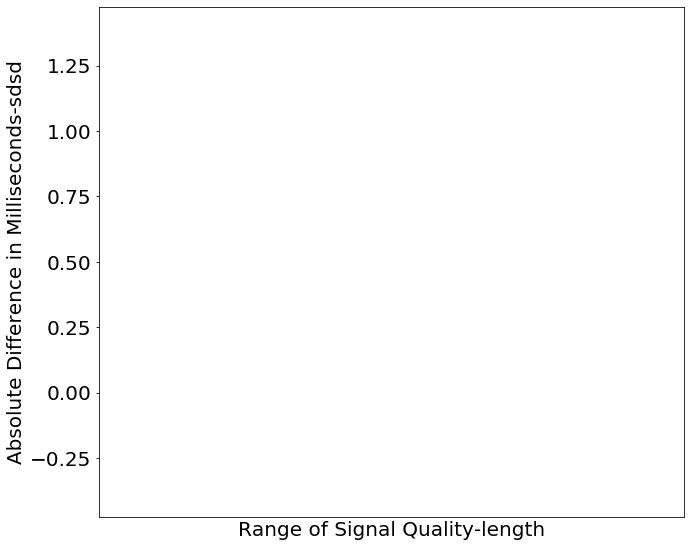

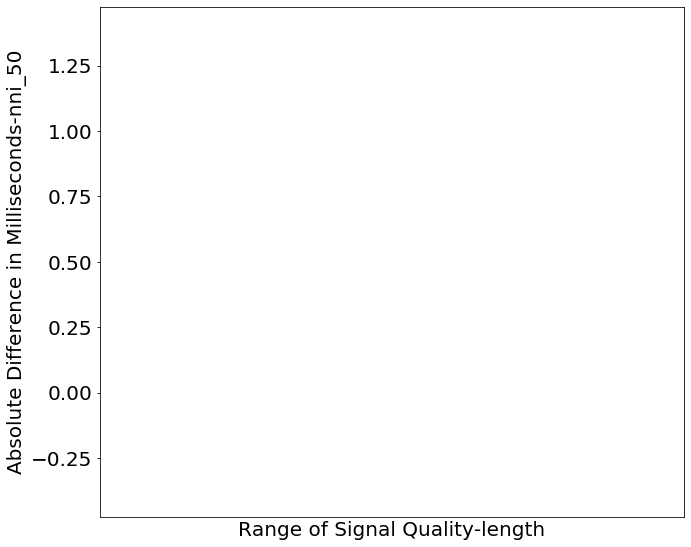

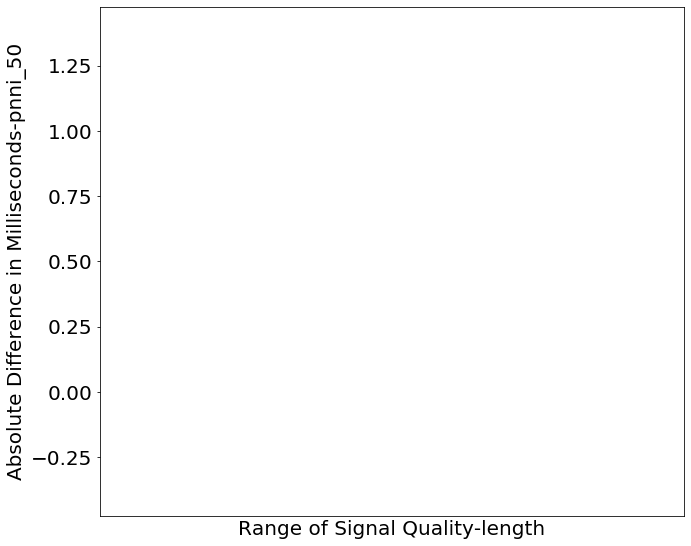

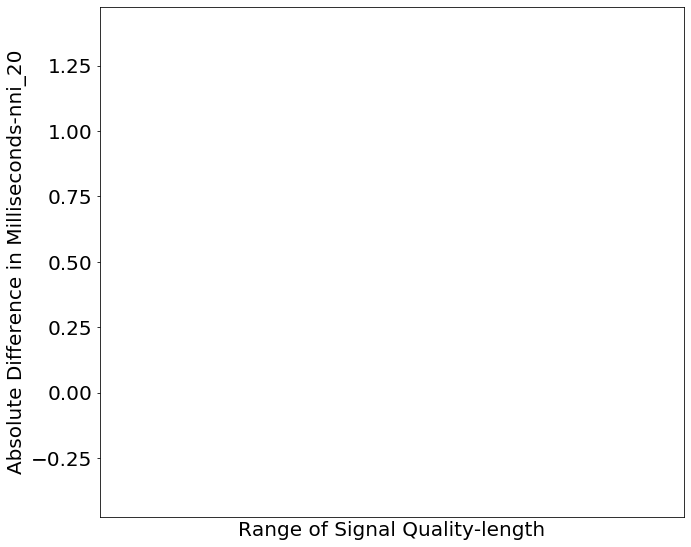

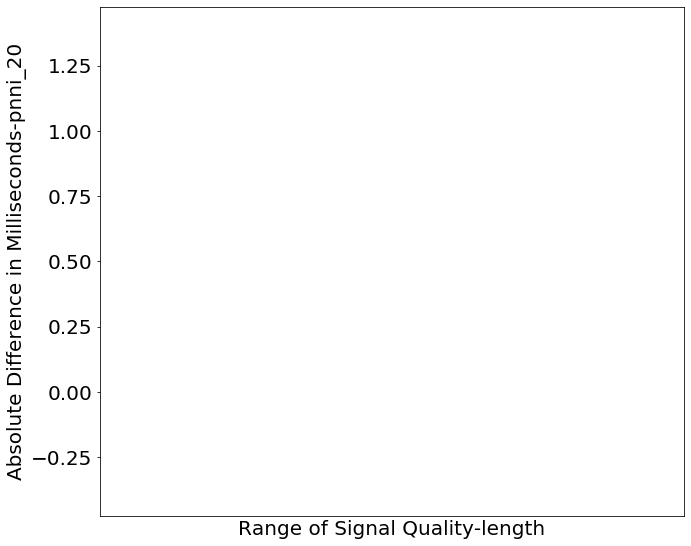

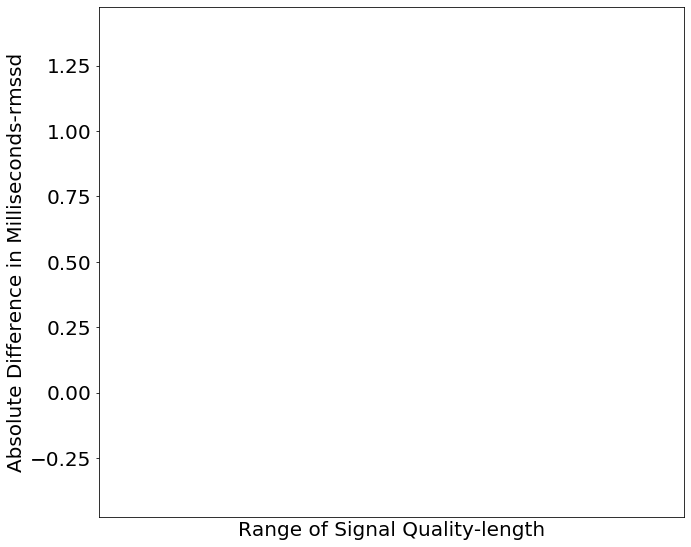

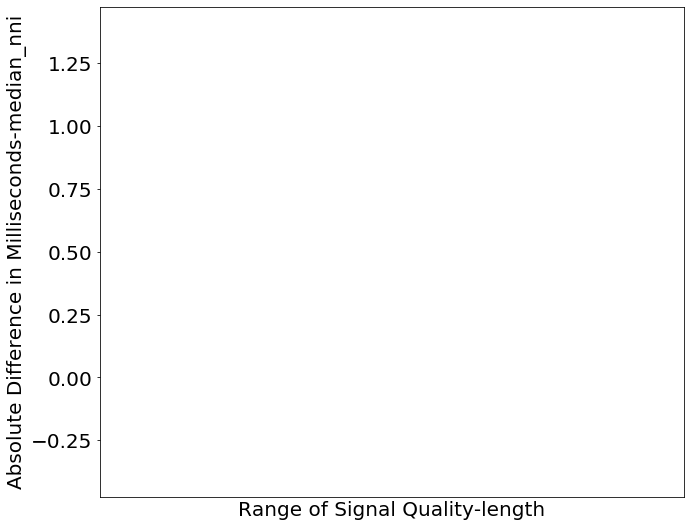

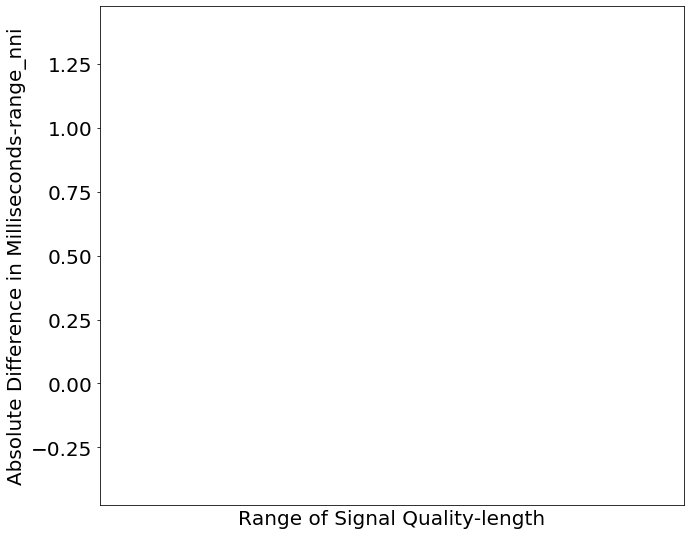

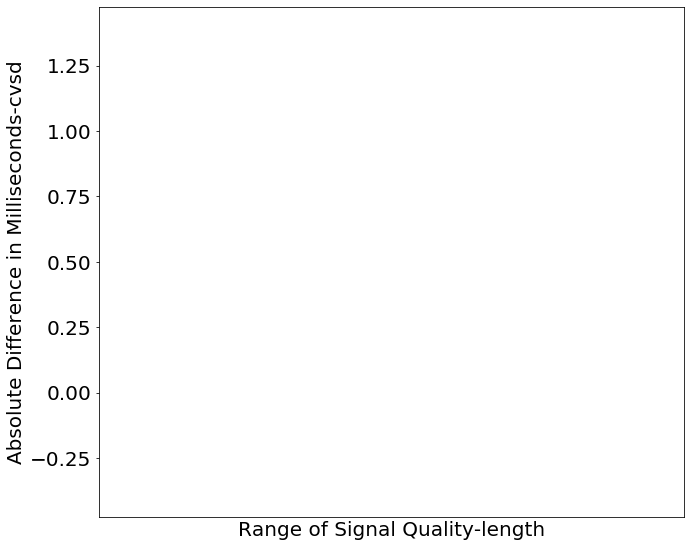

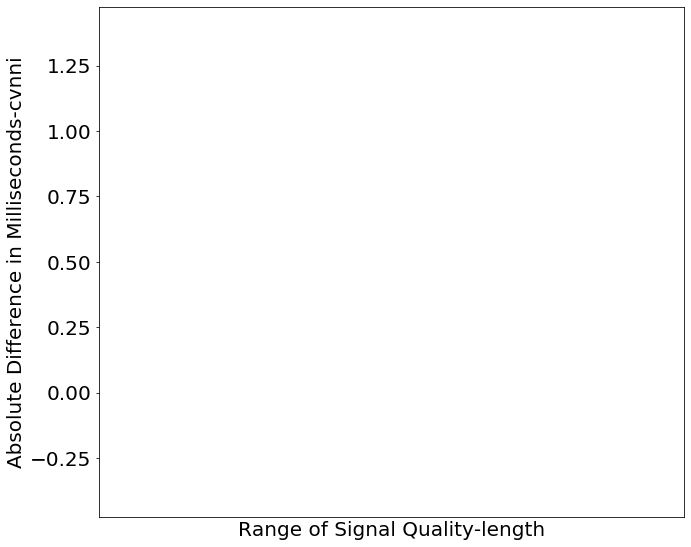

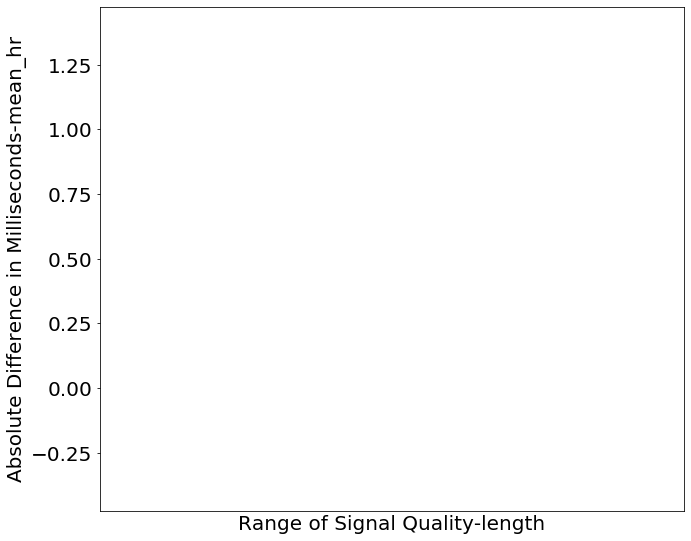

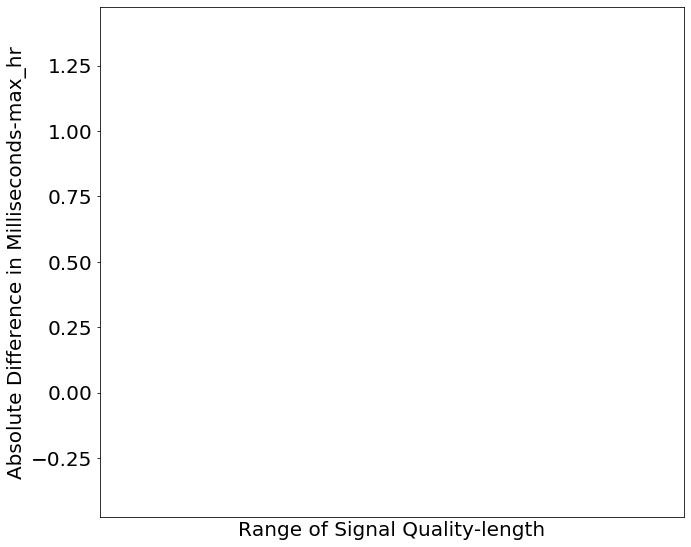

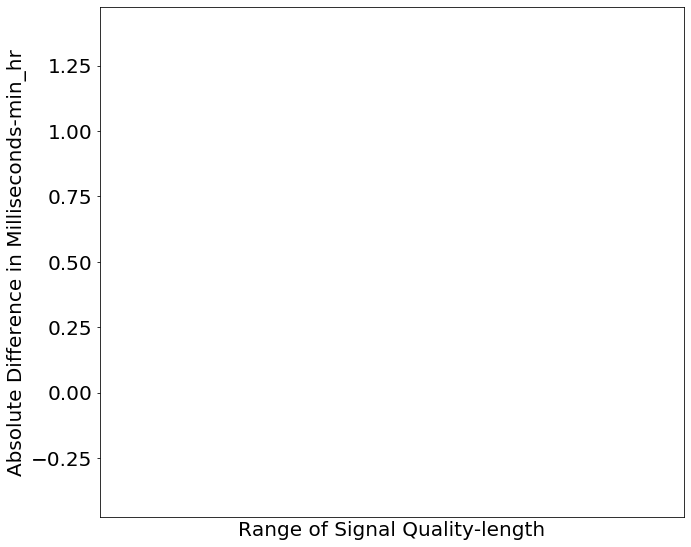

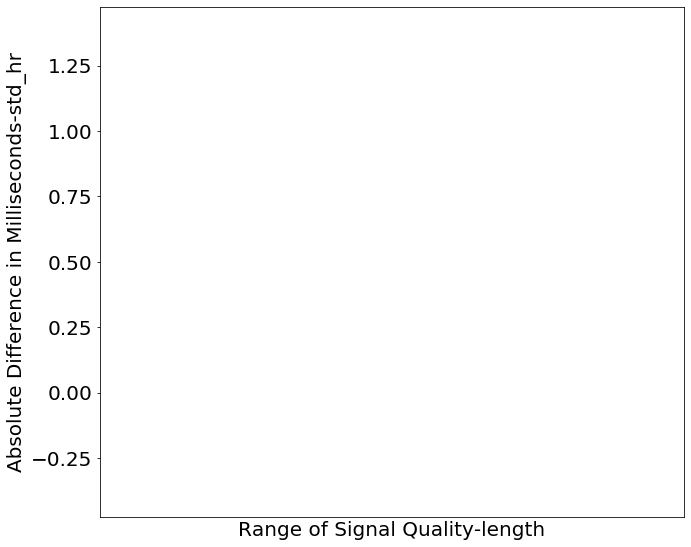

In [70]:
for j,q_name in enumerate(quality_col):
    for i,f_name in enumerate(feature_col):
        input_ppg = features[:,i]
        input_ecg = features_ecg[:,i]
        quals = quality[:,j]
        output(quals,input_ecg,input_ppg,f_name,q_name)
        